<a href="https://colab.research.google.com/github/jagadeesh-usd/receipt-expense-tracker-cv/blob/jaga-dev/notebooks/01_Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Expense Extraction - Receipt Parsing Using YOLO and OCR
### Adaptive Image Preprocessing

#### Objectives
Based on EDA findings, implement **adaptive preprocessing** that:
1. Classifies images by quality (faint/normal/shadowed)
2. Applies appropriate preprocessing strategy per image
3. Optimizes for both OCR readability and YOLO detection
4. Generates processed images for downstream tasks

#### Preprocessing Strategies

##### Strategy 1: Light Preprocessing (Faint Images, STD < 30)
- **Goal:** Enhance contrast without over-processing
- **Steps:**
  1. Minimal denoising (Bilateral filter)
  2. CLAHE with moderate clip limit
  
##### Strategy 2: Medium Preprocessing (Normal Images, STD 30-55)
- **Goal:** Standard enhancement for typical receipts
- **Steps:**
  1. Gaussian blur for noise reduction
  2. CLAHE for contrast improvement
  
##### Strategy 3: Heavy Preprocessing (Shadowed Images, STD > 55)
- **Goal:** Remove shadows and background
- **Steps:**
  1. Gaussian blur
  2. Adaptive thresholding for background removal

#### Setup & Imports

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
# Determine if running in Google Colab and set paths accordingly
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = Path('/content/drive/MyDrive/data')
else:
    DATA_PATH = Path('../data')
    print("Not running in Google Colab. Skipping Google Drive mounting.")

# Configuration
RAW_DIR = DATA_PATH / "raw/SROIE2019"
PROCESSED_DIR = DATA_PATH / "processed/SROIE2019"

# Verify paths
for directory in [RAW_DIR, PROCESSED_DIR]:
    print(f"{'Raw' if directory == RAW_DIR else 'Output'} directory: {directory}")
    print(f"{'Raw' if directory == RAW_DIR else 'Output'} dir exists: {directory.exists()}")


Mounted at /content/drive
Raw directory: /content/drive/MyDrive/data/raw/SROIE2019
Raw dir exists: True
Output directory: /content/drive/MyDrive/data/processed/SROIE2019
Output dir exists: True


#### 1. Core Preprocessing Functions

In [3]:
# UTILITY FUNCTIONS
def load_image(path):
    """
    Load image from path with error handling.

    Args:
        path: Path to image file

    Returns:
        numpy.ndarray: Loaded image in BGR format

    Raises:
        FileNotFoundError: If image cannot be loaded
    """
    img = cv2.imread(str(path))
    if img is None:
        raise FileNotFoundError(f"Could not load image: {path}")
    return img


def to_grayscale(img):
    """
    Convert BGR image to grayscale.

    Args:
        img: BGR image

    Returns:
        numpy.ndarray: Grayscale image
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def classify_receipt(gray):
    """
    Classify receipt quality based on contrast (standard deviation).

    Classification Rules (from EDA):
    - std < 30: Faint/low contrast → Light processing
    - 30 ≤ std ≤ 55: Normal → Medium processing
    - std > 55: Shadowed/high contrast → Heavy processing

    Args:
        gray: Grayscale image

    Returns:
        str: Quality category ('light', 'medium', or 'heavy')
    """
    std = np.std(gray)
    mean = np.mean(gray)

    if std < 30:
        return 'light', std, mean
    elif 30 <= std <= 55:
        return 'medium', std, mean
    else:
        return 'heavy', std, mean

#### 2. Adaptive Preprocessing Strategies

In [4]:
# PREPROCESSING STRATEGIES

def preprocess_light(gray):
    """
    Light preprocessing for faint/low-contrast images.

    Strategy:
    1. Minimal denoising with bilateral filter (preserves edges)
    2. Moderate CLAHE to enhance faint text without over-processing

    Args:
        gray: Grayscale image

    Returns:
        numpy.ndarray: Enhanced grayscale image
    """
    # Step 1: Minimal denoising (preserves edges better than Gaussian)
    denoised = cv2.bilateralFilter(gray, d=5, sigmaColor=50, sigmaSpace=50)

    # Step 2: CLAHE with moderate clip limit for faint text
    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8, 8))
    enhanced = clahe.apply(denoised)

    return enhanced


def preprocess_medium(gray):
    """
    Medium preprocessing for normal-quality images.

    Strategy:
    1. Gaussian blur for standard noise reduction
    2. CLAHE with balanced parameters

    Args:
        gray: Grayscale image

    Returns:
        numpy.ndarray: Enhanced grayscale image
    """
    # Step 1: Standard Gaussian blur for noise reduction
    # Kernel (3,3): Small kernel to reduce noise without losing detail
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Step 2: Balanced CLAHE for contrast enhancement
    # clipLimit=2.5: Moderate enhancement without artifacts
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    return enhanced


def preprocess_heavy(gray):
    """
    Heavy preprocessing for shadowed/high-contrast images.

    Strategy:
    1. Gaussian blur for noise reduction
    2. Adaptive thresholding to remove shadows and backgrounds

    Args:
        gray: Grayscale image

    Returns:
        numpy.ndarray: Binary image with background removed
    """
    # Step 1: More aggressive blur for shadow smoothing
    # Kernel (5,5): Larger kernel to smooth shadows
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Step 2: Adaptive thresholding for shadow/background removal
    # ADAPTIVE_THRESH_GAUSSIAN_C: Better for uneven illumination
    # blockSize=31: Large block to handle shadow variations
    # C=5: Subtracted constant (fine-tuned for receipts)
    binary = cv2.adaptiveThreshold(
        blurred,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=31,
        C=5
    )

    return binary

#### 3. Main Preprocessing Pipeline

In [5]:
# MAIN PIPELINE

def preprocess_image(img_path):
    """
    Main preprocessing controller that routes images to appropriate strategy.

    Workflow:
    1. Load image
    2. Convert to grayscale
    3. Classify quality
    4. Apply appropriate preprocessing

    Args:
        img_path: Path to input image

    Returns:
        tuple: (processed_image, quality_category, std, mean)
    """
    # Load and convert to grayscale
    img = load_image(img_path)
    gray = to_grayscale(img)

    # Classify image quality
    category, std, mean = classify_receipt(gray)

    # Route to appropriate preprocessing strategy
    if category == 'light':
        processed = preprocess_light(gray)
    elif category == 'medium':
        processed = preprocess_medium(gray)
    else:  # heavy
        processed = preprocess_heavy(gray)

    return processed, category, std, mean


def save_preprocessed_image(img_path, output_path):
    """
    Process and save a single image.

    Args:
        img_path: Path to input image
        output_path: Path to save processed image

    Returns:
        dict: Processing metadata (category, std, mean, success)
    """
    try:
        # Process image
        processed, category, std, mean = preprocess_image(img_path)

        # Ensure output directory exists
        Path(output_path).parent.mkdir(parents=True, exist_ok=True)

        # Save processed image
        cv2.imwrite(str(output_path), processed)

        return {
            'filename': Path(img_path).name,
            'category': category,
            'std': std,
            'mean': mean,
            'success': True
        }

    except Exception as e:
        return {
            'filename': Path(img_path).name,
            'category': 'error',
            'std': 0,
            'mean': 0,
            'success': False,
            'error': str(e)
        }

#### 4. Batch Processing

In [ ]:
def process_dataset(splits=['train', 'test']):
    """
    Process all images in the dataset.

    Args:
        splits: List of splits to process (e.g., ['train', 'test'])

    Returns:
        dict: Processing statistics per split
    """
    stats = {}

    for split in splits:
        print(f"\n{'='*60}")
        print(f"Processing {split.upper()} set")
        print(f"{'='*60}")

        # Define paths
        input_dir = RAW_DIR / split / "img"
        output_dir = PROCESSED_DIR / split

        # Get all image files
        image_files = list(input_dir.glob("*.jpg")) + list(input_dir.glob("*.png"))
        print(f"Found {len(image_files)} images")

        # Process images
        results = []
        for img_path in tqdm(image_files, desc=f"Processing {split}"):
            output_path = output_dir / img_path.name
            result = save_preprocessed_image(str(img_path), str(output_path))
            results.append(result)

        # Calculate statistics
        successful = [r for r in results if r['success']]
        failed = [r for r in results if not r['success']]

        categories = {}
        for r in successful:
            cat = r['category']
            categories[cat] = categories.get(cat, 0) + 1

        stats[split] = {
            'total': len(results),
            'successful': len(successful),
            'failed': len(failed),
            'categories': categories
        }

        # Print summary
        print(f"\n{split.upper()} Summary:")
        print(f"  Total: {stats[split]['total']}")
        print(f"  Successful: {stats[split]['successful']}")
        print(f"  Failed: {stats[split]['failed']}")
        print(f"\n  Category Distribution:")
        for cat, count in categories.items():
            percentage = (count / len(successful)) * 100
            print(f"    {cat}: {count} ({percentage:.1f}%)")

        if failed:
            print(f"\n  ⚠️ Failed images:")
            for r in failed[:5]:  # Show first 5 errors
                print(f"    - {r['filename']}: {r.get('error', 'Unknown error')}")

    return stats

# Execute batch processing
print("Starting batch preprocessing...\n")
processing_stats = process_dataset(['train', 'test'])

print(f"\n\n{'='*60}")
print("PREPROCESSING COMPLETE!")
print(f"{'='*60}")
print(f"\nProcessed images saved to: {PROCESSED_DIR}")

#### 5. Visual Verification: Before vs After

Visualizing preprocessing results...



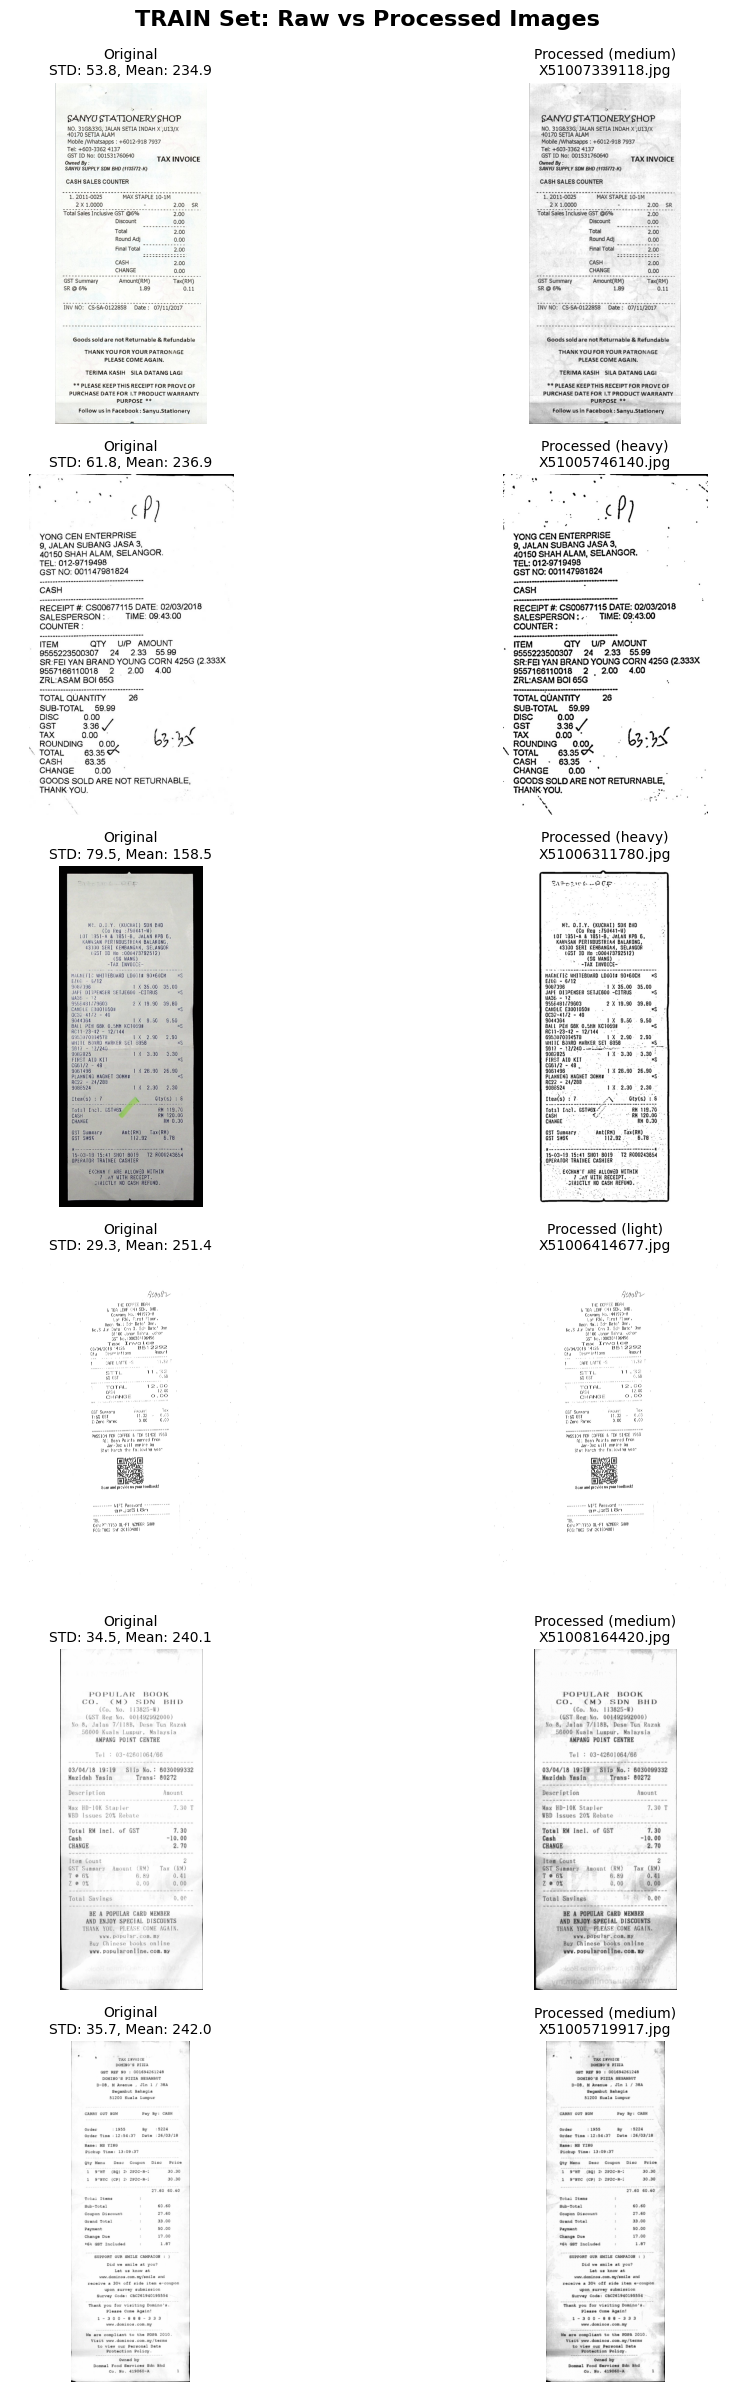

In [7]:
def visualize_preprocessing_results(split='train', n_samples=6):
    """
    Visualize original vs processed images with quality category labels.
    """
    raw_dir = RAW_DIR / split / "img"
    proc_dir = PROCESSED_DIR / split

    # Get random samples
    image_files = list(raw_dir.glob("*.jpg"))[:n_samples]

    # Create figure
    fig, axes = plt.subplots(n_samples, 2, figsize=(12, 4*n_samples))
    fig.suptitle(f'{split.upper()} Set: Raw vs Processed Images',
                 fontsize=16, fontweight='bold', y=0.995)

    for idx, img_path in enumerate(image_files):
        # Load raw image
        raw_img = cv2.imread(str(img_path))
        raw_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
        raw_gray = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)

        # Get category
        category, std, mean = classify_receipt(raw_gray)

        # Load processed image
        proc_path = proc_dir / img_path.name
        proc_img = cv2.imread(str(proc_path), cv2.IMREAD_GRAYSCALE)

        # Display
        axes[idx, 0].imshow(raw_rgb)
        axes[idx, 0].set_title(f'Original\nSTD: {std:.1f}, Mean: {mean:.1f}', fontsize=10)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(proc_img, cmap='gray')
        axes[idx, 1].set_title(f'Processed ({category})\n{img_path.name}', fontsize=10)
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize results
print("Visualizing preprocessing results...\n")
visualize_preprocessing_results('train', n_samples=6)

#### 6. Summary

##### Adaptive Processing Applied:
- **Faint images:** Enhanced with CLAHE
- **Normal images:** Balanced preprocessing
- **Shadowed images:** Background removed via adaptive thresholding

##### Benefits for Downstream Tasks:
1. **OCR (Tesseract/EasyOCR):** Cleaner text, better character recognition
2. **Consistency:** All images processed to similar quality level